<a href="https://colab.research.google.com/github/lotrmay/bakalarska_prace/blob/main/bakalarska_prace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

In [ ]:
import tensorflow as tf
import pickle
import keras
import numpy as np #better arrays in python, lepší práce s multidimenzionálními poli
import pandas as pd #data analytics tool, lepší manipulace s daty, dokáže například cut outnout column
import matplotlib.pyplot as plt #vizualizace tabulek a grafů
import sklearn
import math
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

#CSV_COLUMN_NAMES označuje nadpisy sloupců v csv soubour
CSV_COLUMN_NAMES=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg','Match_link','Result','team_one_name','team_two_name']

dataset=pd.read_csv('/content/data.csv',sep=";",names=CSV_COLUMN_NAMES,error_bad_lines=False,header=None)
print(dataset.shape)

#Odstraním z dataframu následující sloupce (odkaz na zápas a jména týmů), jelikož jsem je využíval pouze při sběru dat
dataset.pop('Match_link')
dataset.pop('team_one_name')
dataset.pop('team_two_name')
#https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
#frac=1 znamená, vrať všechny řádky
dataset = dataset.sample(frac=1).reset_index(drop=True) #náhodně zamícháme řádky

main_scaler=sklearn.preprocessing.StandardScaler()
y = dataset['Result'].values
dataset.pop('Result')
X = dataset.values


(18930, 102)


In [ ]:
#určíme outliers (odlehlé hodnoty, které by mohly být při tréninku pro model škodlivé)
#5% dat 
#https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

lof = LocalOutlierFactor(contamination=0.03)
yhat = lof.fit_predict(X)
mask = yhat != -1
X, y = X[mask, :], y[mask]
print(X.shape, y.shape)


(18362, 98) (18362,)


In [ ]:
#rozdělíme náš dataframe na trénovací, testovací a validační dataset
#testovací dataset bude 15% 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

#validační set bude 15% 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.1764) # 0.1764 x 0.859 = 0.15 

print(X_train.shape) 
print(X_test.shape)
print(X_val.shape) 

#scalujeme data aby si model nemyslel, že větší číselný řád indikuje větší důležitost atributu
main_scaler.fit(X_train)#model pracuje jen s poznatky, které získal na trénovacím datasetu, proto později používám pouze transform na trénovacím datasetu

X_train=main_scaler.transform(X_train)#:https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data
X_test=main_scaler.transform(X_test)
X_val=main_scaler.transform(X_val)

(12853, 98)
(2755, 98)
(2754, 98)


In [ ]:
import optuna
def objective(trial):
    bs  = int(math.pow(2,trial.suggest_int('batch size', 6, 9)))
    opt_name = trial.suggest_categorical('optimizer', ['Adagrad'])
    lr=trial.suggest_uniform('lr', 1e-2, 1e-0)
    min_learning_rate=trial.suggest_uniform('minimum_learning_rate', 1e-5, 1e-2)
    opt=keras.optimizers.get(opt_name)
    opt.learning_rate=lr

    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(98)))
    model.add(keras.layers.Dropout(rate=0.2)) 
    model.add(keras.layers.Dense(64,activation='relu'))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(32,activation='relu'))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=opt, 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=['binary_accuracy'])

    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=min_learning_rate,verbose=0)
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)

    model.fit(X_train, y_train, epochs=200, shuffle=True,batch_size=bs,validation_data=(X_val, y_val), callbacks=[reduce_lr_callback,early_stopping_callback])
    return model.evaluate(X_test, y_test, verbose=0)[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('params:', study.best_trial.params)
print('best accuracy:', study.best_value)


Epoch 1/200
101/101 [==============================] - 1s 4ms/step - loss: 0.6546 - binary_accuracy: 0.6237 - val_loss: 0.6329 - val_binary_accuracy: 0.6412

Epoch 00001: val_loss improved from inf to 0.63294, saving model to current_model.h5
Epoch 2/200
101/101 [==============================] - 0s 2ms/step - loss: 0.6192 - binary_accuracy: 0.6556 - val_loss: 0.6190 - val_binary_accuracy: 0.6489

Epoch 00002: val_loss improved from 0.63294 to 0.61898, saving model to current_model.h5
Epoch 3/200
101/101 [==============================] - 0s 2ms/step - loss: 0.6160 - binary_accuracy: 0.6586 - val_loss: 0.6183 - val_binary_accuracy: 0.6550

Epoch 00003: val_loss improved from 0.61898 to 0.61833, saving model to current_model.h5
Epoch 4/200
101/101 [==============================] - 0s 3ms/step - loss: 0.6111 - binary_accuracy: 0.6681 - val_loss: 0.6195 - val_binary_accuracy: 0.6569

Epoch 00004: val_loss did not improve from 0.61833
Epoch 5/200
101/101 [==============================] -

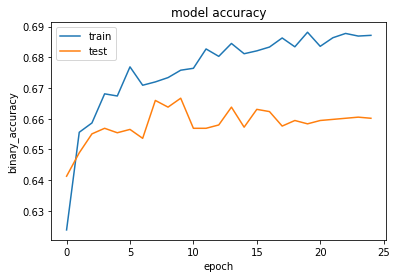

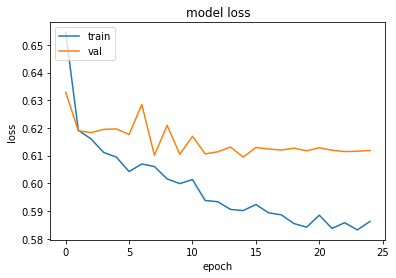

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(98)))
model.add(keras.layers.Dropout(rate=0.2)) 
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.373), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
              metrics=['binary_accuracy'])

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.004,verbose=1)
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('current_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)#patience-kolik epoch se nezmění val_loss pak stop

history = model.fit(X_train, y_train, epochs=200, shuffle=True,batch_size=128,validation_data=(X_val, y_val), 
                    callbacks=[reduce_lr_callback,checkpoint_callback,early_stopping_callback])#steps
train_predictions= model.predict(X_train)
train_accuracy_score = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {:.2%} \n Error on training data: {:.2%}'.format(train_accuracy_score[1],  1 - train_accuracy_score[1]))#úspěšnost na trénovacím setu   


test_predictions= model.predict(X_test)
test_accuracy_score= model.evaluate(X_test, y_test, verbose=0)# zkusit změnit verbose zde a nahoře na 1 a 2 mělo by to zobrazovat více údajů při tréninku
print('Accuracy on test data: {:.2%} \n Error on test data: {:.2%}'.format(test_accuracy_score[1], 1 - test_accuracy_score[1]))#úspěšnost na testovacím setu

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#model.save('/content/save/model707.h5')
model= keras.models.load_model("current_model.h5")
pred_test= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=1)
print('Accuracy on the training dataset: {:.2%} \n Error on the training dataset: {:.2%}'.format(scores[1], 1 - scores[1]))#úspěšnost na trénovacím datasetu

pred_test= model.predict(X_val)
scores = model.evaluate(X_val, y_val, verbose=1)
print('Accuracy on the validation dataset: {:.2%} \n Error on the validation dataset: {:.2%}'.format(scores[1], 1 - scores[1]))#úspěšnost na validačním datasetu

pred_test= model.predict(X_test)
scores = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy on the test dataset: {:.2%} \n Error on the test dataset: {:.2%}'.format(scores[1], 1 - scores[1]))#úspěšnost na testovacím datasetu


scaledData=main_scaler.transform(X)
pred_test= model.predict(scaledData)
scores = model.evaluate(scaledData, y, verbose=1)
print('Accuracy on the whole dataset: {:.2%} \n Error on the whole dataset: {:.2%}'.format(scores[1], 1 - scores[1]))#úspěšnost na celém datasetu


#pickle.dump(main_scaler, open("/content/save/scaler707.pkl", 'wb'))#save the scaler 

402/402 [==============================] - 1s 1ms/step - loss: 0.5673 - binary_accuracy: 0.7019
Accuracy on the training dataset: 70.19% 
 Error on the training dataset: 29.81%
87/87 [==============================] - 0s 1ms/step - loss: 0.6095 - binary_accuracy: 0.6572
Accuracy on the validation dataset: 65.72% 
 Error on the validation dataset: 34.28%
87/87 [==============================] - 0s 1ms/step - loss: 0.6066 - binary_accuracy: 0.6624
Accuracy on the test dataset: 66.24% 
 Error on the test dataset: 33.76%
574/574 [==============================] - 1s 1ms/step - loss: 0.5795 - binary_accuracy: 0.6892
Accuracy on the whole dataset: 68.92% 
 Error on the whole dataset: 31.08%


In [ ]:
main_scaler = pickle.load(open("scaler707.pkl", 'rb'))
X_new=np.array([[1.6,2.25,26,44,0.63,0.64,0.464,0.578,1.18,0.76,0.72,1.28,88.3,0.82,0.66,1.08,5.2,1.14,0.58,0.73,1.09,73.2,0.71,0.3,1.23,3.0,1.08,0.63,0.74,0.97,75.1,0.65,0.45,1.03,5.9,1.07,0.64,0.72,1.0,74.7,0.67,0.45,1.05,3.3,0.99,0.64,0.72,0.89,67.3,0.59,0.53,0.92,7.0,1.2,0.66,0.73,1.29,85.5,0.76,0.49,1.17,7.6,1.08,0.59,0.72,1.07,66.6,0.67,0.29,1.12,2.5,1.07,0.63,0.72,1.02,72.1,0.67,0.57,1.05,5.1,1.06,0.61,0.74,0.93,72.3,0.67,0.53,1.08,5.4,1.02,0.67,0.72,0.99,74.0,0.62,0.46,0.93,9.4],
               [2.62,1.47,165,129,0.47,0.67,0.5,0.5,1.24,0.68,0.76,1.24,86.3,0.83,0.58,1.23,4.6,1.09,0.67,0.71,1.11,74.9,0.68,0.41,1.01,5.2,1.03,0.68,0.72,0.99,71.8,0.67,0.56,0.99,2.6,0.98,0.72,0.68,0.95,73.2,0.65,0.4,0.90,3.4,0.96,0.67,0.69,0.9,65.9,0.61,0.48,0.91,2.3,1.2,0.68,0.73,1.23,87.0,0.78,0.55,1.15,6.7,1.14,0.58,0.74,1.14,68.7,0.68,0.38,1.17,3.4,1.13,0.67,0.71,1.28,76.3,0.71,0.59,1.05,4.0,1.06,0.63,0.72,0.9,73.9,0.7,0.61,1.10,5.1,1.04,0.69,0.71,1.01,74.2,0.68,0.6,0.99,3.9],
               [2.3,1.52,91,72,0.53,0.67,0.5,0.5,1.11,0.62,0.71,1.08,73.1,0.7,0.3,1.13,2.9,1.08,0.66,0.69,1.16,72.6,0.71,0.62,1.09,3.6,1.06,0.68,0.73,0.95,77.2,0.66,0.51,0.98,3.9,1.03,0.66,0.69,0.95,74.8,0.67,0.68,1.01,3.0,0.96,0.64,0.71,0.87,65.7,0.57,0.5,0.89,5.2,1.13,0.6,0.74,1.0,77.5,0.71,0.57,1.20,5.7,1.18,0.57,0.74,1.17,74.4,0.71,0.27,1.25,3.1,1.15,0.66,0.74,1.11,79.8,0.73,0.52,1.11,4.3,1.04,0.67,0.7,1.03,74.4,0.66,0.62,0.98,3.0,0.95,0.68,0.7,0.85,67.0,0.58,0.5,0.85,4.9],
               [1.6,2.27,43,60,0.55,0.5,0.5,0.51,1.06,0.69,0.69,1.1,75.7,0.7,0.55,1.02,4.5,1.13,0.67,0.68,1.26,77.6,0.76,0.32,1.13,1.8,0.97,0.69,0.68,0.93,71.2,0.64,0.54,0.94,4.2,1.05,0.68,0.68,1.1,74.83,0.7,0.47,1.03,3.5,1.05,0.68,0.68,1.1,74.83,0.7,0.47,1.03,3.5,1.14,0.7,0.72,1.17,83.8,0.74,0.53,1.05,4.5,1.03,0.64,0.68,1.04,69.9,0.66,0.3,1.03,3.3,1.0,0.7,0.68,1.06,71.6,0.64,0.59,0.92,2.8,0.95,0.66,0.69,0.84,65.4,0.62,0.64,0.94,2.4,0.95,0.7,0.68,0.86,69.4,0.62,0.55,0.88,2.5],
               [1.74,2.04,65,78,0.67,0.45,0.569,0.5,1.35,0.51,0.78,1.34,82.4,0.84,0.34,1.66,2.8,1.14,0.61,0.72,1.16,77.0,0.7,0.49,1.16,4.5,1.14,0.63,0.72,1.13,80.0,0.7,0.52,1.11,4.6,1.09,0.63,0.71,1.03,76.0,0.7,0.54,1.11,3.7,1.01,0.62,0.72,0.87,68.7,0.61,0.6,0.98,4.2,1.08,0.68,0.71,1.11,77.7,0.7,0.53,1.04,5.0,1.04,0.68,0.68,1.1,75.5,0.69,0.51,1.01,3.6,1.0,0.63,0.69,0.9,67.8,0.63,0.3,1.00,4.4,0.96,0.74,0.64,1.07,74.4,0.64,0.55,0.86,5.8,0.95,0.63,0.71,0.69,67.2,0.6,0.54,0.96,4.3],
               [1.43,2.6,17,36,0.42,0.8,0.595,0.535,1.3,0.6,0.74,1.35,89.4,0.85,0.46,1.41,5.0,1.07,0.64,0.71,0.98,77.0,0.67,0.44,1.06,5.3,1.07,0.7,0.69,1.2,74.4,0.67,0.29,0.97,3.3,0.98,0.66,0.71,0.84,71.3,0.62,0.45,0.94,4.8,0.71,0.65,0.63,0.5,45.6,0.4,0.46,0.62,1.9,1.29,0.57,0.79,1.13,87.2,0.82,0.53,1.44,3.2,1.28,0.56,0.77,1.3,79.6,0.8,0.26,1.43,3.1,1.23,0.62,0.75,1.27,84.0,0.77,0.51,1.23,6.1,1.06,0.65,0.71,1.08,73.0,0.68,0.52,1.04,5.6,1.06,0.6,0.75,0.88,72.2,0.63,0.46,1.04,3.5],
               [2.91,1.39,128,68,0.6,0.75,0.5,0.516,1.12,0.63,0.69,1.2,75.9,0.73,0.27,1.16,4.6,1.08,0.67,0.69,1.1,76.1,0.71,0.47,1.06,4.5,1.03,0.68,0.71,0.92,75.7,0.68,0.53,1.01,2.6,1.0,0.72,0.71,0.99,76.1,0.64,0.39,0.89,4.7,0.9,0.71,0.69,0.81,64.5,0.59,0.46,0.83,3.1,1.17,0.62,0.71,1.2,78.1,0.76,0.25,1.24,2.6,1.08,0.65,0.71,1.08,76.4,0.67,0.55,1.03,5.5,1.07,0.63,0.73,0.93,72.3,0.68,0.55,1.08,3.4,1.05,0.71,0.68,1.2,76.3,0.68,0.43,0.96,3.8,1.04,0.67,0.72,0.98,72.5,0.67,0.55,1.00,3.7]
])

pokus=main_scaler.transform(X_new)
model= keras.models.load_model("model707.h5")
y_new=(model.predict([pokus]))
print(y_new)